In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [2]:
! pip3 install pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession.builder.master("local").getOrCreate()

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/25 20:46:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/25 20:46:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/06/25 20:46:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df_import_package_full = spark.read \
    .csv("../data/full_import_dataset/full_import_dataset_with_package.csv", inferSchema=True, header=True) \
    .drop("_c0")
df_import_package_full.printSchema()
df_import_package_full.show(10)

root
 |-- project_name: string (nullable = true)
 |-- import: string (nullable = true)
 |-- is_kotlin_import: integer (nullable = true)
 |-- is_python_import: integer (nullable = true)
 |-- package: string (nullable = true)

+-----------------+--------------------+----------------+----------------+--------------------+
|     project_name|              import|is_kotlin_import|is_python_import|             package|
+-----------------+--------------------+----------------+----------------+--------------------+
|    2dust#v2rayNG|androidx.appcompa...|               1|               0|androidx.appcompa...|
|InsertKoinIO#koin|androidx.appcompa...|               1|               0|androidx.appcompa...|
|InsertKoinIO#koin|androidx.appcompa...|               1|               0|androidx.appcompa...|
|InsertKoinIO#koin|androidx.appcompa...|               1|               0|androidx.appcompa...|
|InsertKoinIO#koin|androidx.appcompa...|               1|               0|androidx.appcompa...|
|Insert

In [4]:
# Count diff imports of packages in projects
df_package = df_import_package_full \
    .groupby('project_name', 'package') \
    .agg(F.count('import').name('count_different_import'),
         F.first('is_kotlin_import').name('is_kotlin_package'),
         F.first('is_python_import').name('is_python_package'))

df_package.show(10)

+--------------------+-------------------+----------------------+-----------------+-----------------+
|        project_name|            package|count_different_import|is_kotlin_package|is_python_package|
+--------------------+-------------------+----------------------+-----------------+-----------------+
|       2dust#v2rayNG|   android.Manifest|                     5|                1|                0|
|tachiyomiorg#tach...|       android.text|                    16|                1|                0|
|       2dust#v2rayNG|  androidx.activity|                     6|                1|                0|
|   JetBrains#Exposed|          java.util|                   112|                1|                0|
|     walleth#walleth|            java.io|                    12|                1|                0|
|miaowmiaow#fragmject|        android.app|                     8|                1|                0|
|kongpf8848#Animation|  androidx.fragment|                     9|                1

In [5]:
def map_project(is_kotlin_package: int, name: str) -> str:
    tag = 'package'
    lang = 'kotlin' if is_kotlin_package == 1 else 'python'
    return f'{tag}#{lang}#{name}'

In [6]:
map_project_udf=F.udf(map_project, T.StringType())
df_package = df_package.withColumn("package", map_project_udf(F.col("is_kotlin_package"), F.col("package")))
df_package.show(10)

+--------------------+--------------------+----------------------+-----------------+-----------------+
|        project_name|             package|count_different_import|is_kotlin_package|is_python_package|
+--------------------+--------------------+----------------------+-----------------+-----------------+
|       2dust#v2rayNG|package#kotlin#an...|                     5|                1|                0|
|tachiyomiorg#tach...|package#kotlin#an...|                    16|                1|                0|
|       2dust#v2rayNG|package#kotlin#an...|                     6|                1|                0|
|   JetBrains#Exposed|package#kotlin#ja...|                   112|                1|                0|
|     walleth#walleth|package#kotlin#ja...|                    12|                1|                0|
|miaowmiaow#fragmject|package#kotlin#an...|                     8|                1|                0|
|kongpf8848#Animation|package#kotlin#an...|                     9|       

## Package features extraction

In [7]:
pivot_package = df_package.toPandas() \
    .pivot_table(index="project_name", columns="package", values="count_different_import", fill_value=0)

pivot_package.head()

package,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,package#kotlin#POGOProtos,...,package#python#zeroconf,package#python#zigpy,package#python#zipfile,package#python#zipimport,package#python#zlib,package#python#zmq,package#python#zope,package#python#zulint,package#python#zulip_bots,package#python#zwave_js_server
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
pivot_package.shape

(2836, 3982)

### TF-IDF transformation for packages

In [9]:
def tf_idf(t):
    N = pivot_package.shape[0]
    idf = np.log(N / pivot_package[pivot_package[t] > 0].shape[0])
    tf = pivot_package[t] / pivot_package['packages_count']
    return tf * idf

In [10]:
packages = df_package.toPandas()['package'].unique()
pivot_package['packages_count'] = pivot_package[packages].sum(axis=1)

for t in packages:
    pivot_package[t] = tf_idf(t)
    
pivot_package.head()

package,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,package#kotlin#POGOProtos,...,package#python#zigpy,package#python#zipfile,package#python#zipimport,package#python#zlib,package#python#zmq,package#python#zope,package#python#zulint,package#python#zulip_bots,package#python#zwave_js_server,packages_count
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


## Extension features extraction

In [11]:
# Load ext count dataset
df_extension = spark.read \
    .csv("../data/ext_count/full_ext_count_dataset.csv", inferSchema=True, header=True) \
    .drop("_c0").dropna()
df_extension.printSchema()
df_extension.show(10)

root
 |-- project_name: string (nullable = true)
 |-- ext: string (nullable = true)
 |-- count: integer (nullable = true)

+-------------------+-----+-----+
|       project_name|  ext|count|
+-------------------+-----+-----+
|donnemartin#gitsome| .yml|    4|
|donnemartin#gitsome|  .md|   10|
|donnemartin#gitsome|  .py|  345|
|donnemartin#gitsome| .txt|    3|
|donnemartin#gitsome| .ini|    1|
|donnemartin#gitsome| .rst|    1|
|donnemartin#gitsome| .png|    1|
|donnemartin#gitsome|   .p|    3|
|donnemartin#gitsome|.json|    1|
|donnemartin#gitsome|   .c|    1|
+-------------------+-----+-----+
only showing top 10 rows



In [12]:
df_extension.count()

75348

In [13]:
def map_extension(ext: str) -> str:
    tag = 'ext'
    ext = ext[1:]
    return f'{tag}#{ext}'

In [14]:
map_extension_udf = F.udf(map_extension, T.StringType())
df_extension = df_extension.withColumn("ext", map_extension_udf(F.col("ext")))
df_extension.show(10)

+-------------------+--------+-----+
|       project_name|     ext|count|
+-------------------+--------+-----+
|donnemartin#gitsome| ext#yml|    4|
|donnemartin#gitsome|  ext#md|   10|
|donnemartin#gitsome|  ext#py|  345|
|donnemartin#gitsome| ext#txt|    3|
|donnemartin#gitsome| ext#ini|    1|
|donnemartin#gitsome| ext#rst|    1|
|donnemartin#gitsome| ext#png|    1|
|donnemartin#gitsome|   ext#p|    3|
|donnemartin#gitsome|ext#json|    1|
|donnemartin#gitsome|   ext#c|    1|
+-------------------+--------+-----+
only showing top 10 rows



In [15]:
pivot_extension = df_extension.toPandas().pivot_table(index="project_name", columns="ext", values="count", fill_value=0)
pivot_extension.head()

ext,ext#,ext#0,ext#0+,ext#0-AT,ext#0-Combined-Work-Exception,ext#0-DE,ext#0-FR,ext#0-IGO,ext#0-NL,ext#0-Perl,...,ext#zktx,ext#zlib,ext#zmpl,ext#zone,ext#zoneinfo,ext#zpln,ext#zraw,ext#zsh,ext#zst,ext#zzz
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
pivot_extension.shape

(3404, 3852)

In [17]:
def tf(t):
    tf = pivot_extension[t] / (pivot_extension['ext_count'] + 1)
    return tf

In [18]:
extensions = df_extension.toPandas()['ext'].unique()
pivot_extension['ext_count'] = pivot_extension[extensions].sum(axis=1)

for t in extensions:
    pivot_extension[t] = tf(t)
    
pivot_extension.head()

ext,ext#,ext#0,ext#0+,ext#0-AT,ext#0-Combined-Work-Exception,ext#0-DE,ext#0-FR,ext#0-IGO,ext#0-NL,ext#0-Perl,...,ext#zlib,ext#zmpl,ext#zone,ext#zoneinfo,ext#zpln,ext#zraw,ext#zsh,ext#zst,ext#zzz,ext_count
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2492.0
05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0


## Kaggle dataset

In [19]:
# Load kaggle_repos dataframe
df_kaggle = spark.read \
    .csv("../data/kaggle_repos/kaggle_repos.csv", inferSchema=True, header=True) \
    .drop("_c0")
df_kaggle.printSchema()
df_kaggle.toPandas().head()

root
 |-- topic: string (nullable = true)
 |-- name: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- owner_type: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- og_image: string (nullable = true)
 |-- license: string (nullable = true)
 |-- is_archived: string (nullable = true)
 |-- is_forked: string (nullable = true)
 |-- size: string (nullable = true)
 |-- language: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- open_issues: string (nullable = true)
 |-- forks: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- watchers: string (nullable = true)
 |-- has_wiki: string (nullable = true)
 |-- has_pages: string (nullable = true)
 |-- has_sponsorship: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- repo: string (nullable = true)



,topic,name,owner,owner_type,full_name,description,og_image,license,is_archived,is_forked,...,open_issues,forks,stars,watchers,has_wiki,has_pages,has_sponsorship,created_at,updated_at,repo
0,3d,SpaceshipGenerator,a1studmuffin,User,a1studmuffin/SpaceshipGenerator,A Blender script to procedurally generate 3D s...,None,Other,False,False,...,13,391,7100,7100,True,False,False,2016-06-14T03:16:07Z,2022-04-06T16:55:48Z,https://github.com/a1studmuffin/SpaceshipGener...
1,3d,BlenderGIS,domlysz,User,domlysz/BlenderGIS,None,None,GNU General Public License v3.0,False,False,...,155,923,5047,5047,True,False,False,2014-05-08T14:48:25Z,2022-04-08T00:59:56Z,https://github.com/domlysz/BlenderGIS
2,3d,PRNet,YadiraF,User,YadiraF/PRNet,Joint 3D Face Reconstruction and Dense Alignme...,None,MIT License,False,False,...,160,919,4574,4574,True,False,False,2018-03-20T11:44:06Z,2022-04-08T03:00:19Z,https://github.com/YadiraF/PRNet
3,3d,3DDFA,cleardusk,User,cleardusk/3DDFA,The PyTorch improved version of TPAMI 2017 pap...,None,MIT License,False,False,...,51,621,3223,3223,False,False,False,2018-06-29T14:19:21Z,2022-04-07T07:47:09Z,https://github.com/cleardusk/3DDFA
4,3d,armory,armory3d,Organization,armory3d/armory,None,None,zlib License,False,False,...,310,263,2421,2421,True,False,False,2015-10-29T18:27:56Z,2022-04-06T21:17:40Z,https://github.com/armory3d/armory


In [20]:
df_kaggle.columns

['topic',
 'name',
 'owner',
 'owner_type',
 'full_name',
 'description',
 'og_image',
 'license',
 'is_archived',
 'is_forked',
 'size',
 'language',
 'tags',
 'open_issues',
 'forks',
 'stars',
 'watchers',
 'has_wiki',
 'has_pages',
 'has_sponsorship',
 'created_at',
 'updated_at',
 'repo']

In [21]:
# Prepare column for join
df_kaggle = df_kaggle.withColumn("project_name", F.concat(F.col("owner"), F.lit("#"), F.col("name")))
df_kaggle.toPandas().head()

,topic,name,owner,owner_type,full_name,description,og_image,license,is_archived,is_forked,...,forks,stars,watchers,has_wiki,has_pages,has_sponsorship,created_at,updated_at,repo,project_name
0,3d,SpaceshipGenerator,a1studmuffin,User,a1studmuffin/SpaceshipGenerator,A Blender script to procedurally generate 3D s...,None,Other,False,False,...,391,7100,7100,True,False,False,2016-06-14T03:16:07Z,2022-04-06T16:55:48Z,https://github.com/a1studmuffin/SpaceshipGener...,a1studmuffin#SpaceshipGenerator
1,3d,BlenderGIS,domlysz,User,domlysz/BlenderGIS,None,None,GNU General Public License v3.0,False,False,...,923,5047,5047,True,False,False,2014-05-08T14:48:25Z,2022-04-08T00:59:56Z,https://github.com/domlysz/BlenderGIS,domlysz#BlenderGIS
2,3d,PRNet,YadiraF,User,YadiraF/PRNet,Joint 3D Face Reconstruction and Dense Alignme...,None,MIT License,False,False,...,919,4574,4574,True,False,False,2018-03-20T11:44:06Z,2022-04-08T03:00:19Z,https://github.com/YadiraF/PRNet,YadiraF#PRNet
3,3d,3DDFA,cleardusk,User,cleardusk/3DDFA,The PyTorch improved version of TPAMI 2017 pap...,None,MIT License,False,False,...,621,3223,3223,False,False,False,2018-06-29T14:19:21Z,2022-04-07T07:47:09Z,https://github.com/cleardusk/3DDFA,cleardusk#3DDFA
4,3d,armory,armory3d,Organization,armory3d/armory,None,None,zlib License,False,False,...,263,2421,2421,True,False,False,2015-10-29T18:27:56Z,2022-04-06T21:17:40Z,https://github.com/armory3d/armory,armory3d#armory


## Repos tags extraction

In [22]:
df_kaggle_tags = df_kaggle.select("project_name", "tags")
df_kaggle_tags.show(10)

+--------------------+--------------------+
|        project_name|                tags|
+--------------------+--------------------+
|a1studmuffin#Spac...|['python', 'proce...|
|  domlysz#BlenderGIS|                  []|
|       YadiraF#PRNet|['swap', 'face', ...|
|     cleardusk#3DDFA|['python', 'compu...|
|     armory3d#armory|                  []|
|  cleardusk#3DDFA_V2|['computer-vision...|
|   CadQuery#cadquery|                  []|
|facebookresearch#...|['deep-learning',...|
|charlesq34#frustu...|['deep-learning',...|
| nywang16#Pixel2Mesh|['mesh', 'reconst...|
+--------------------+--------------------+
only showing top 10 rows



In [23]:
def literal_eval(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

literal_eval_udf = F.udf(literal_eval, T.ArrayType(T.StringType()))
df_kaggle_tags = df_kaggle_tags.withColumn("tags", literal_eval_udf(F.col("tags")))
df_kaggle_tags.show(10)

+--------------------+--------------------+
|        project_name|                tags|
+--------------------+--------------------+
|a1studmuffin#Spac...|[python, procedur...|
|  domlysz#BlenderGIS|                  []|
|       YadiraF#PRNet|[swap, face, alig...|
|     cleardusk#3DDFA|[python, computer...|
|     armory3d#armory|                  []|
|  cleardusk#3DDFA_V2|[computer-vision,...|
|   CadQuery#cadquery|                  []|
|facebookresearch#...|[deep-learning, r...|
|charlesq34#frustu...|[deep-learning, r...|
| nywang16#Pixel2Mesh|[mesh, reconstruc...|
+--------------------+--------------------+
only showing top 10 rows



In [24]:
# Prepare dataset for pivot
df_kaggle_tags = df_kaggle_tags.select("project_name", F.explode("tags").name("tags"))
df_kaggle_tags.show(10)

+--------------------+--------------------+
|        project_name|                tags|
+--------------------+--------------------+
|a1studmuffin#Spac...|              python|
|a1studmuffin#Spac...|procedural-genera...|
|a1studmuffin#Spac...|     blender-scripts|
|a1studmuffin#Spac...|    game-development|
|a1studmuffin#Spac...|                  3d|
|a1studmuffin#Spac...|           spaceship|
|       YadiraF#PRNet|                swap|
|       YadiraF#PRNet|                face|
|       YadiraF#PRNet|           alignment|
|       YadiraF#PRNet|      reconstruction|
+--------------------+--------------------+
only showing top 10 rows



In [25]:
df_kaggle_tags = df_kaggle_tags.withColumn("val", F.lit(1))
df_kaggle_tags.show(10)

+--------------------+--------------------+---+
|        project_name|                tags|val|
+--------------------+--------------------+---+
|a1studmuffin#Spac...|              python|  1|
|a1studmuffin#Spac...|procedural-genera...|  1|
|a1studmuffin#Spac...|     blender-scripts|  1|
|a1studmuffin#Spac...|    game-development|  1|
|a1studmuffin#Spac...|                  3d|  1|
|a1studmuffin#Spac...|           spaceship|  1|
|       YadiraF#PRNet|                swap|  1|
|       YadiraF#PRNet|                face|  1|
|       YadiraF#PRNet|           alignment|  1|
|       YadiraF#PRNet|      reconstruction|  1|
+--------------------+--------------------+---+
only showing top 10 rows



In [26]:
# Rename each tag name to avoid name collision with package names
def map_tag(tag: str) -> str:
    return f'tag#{tag}'

map_tag_udf = F.udf(map_tag, T.StringType())
df_kaggle_tags = df_kaggle_tags.withColumn("tags", map_tag_udf(F.col("tags")))
df_kaggle_tags.show(10)

+--------------------+--------------------+---+
|        project_name|                tags|val|
+--------------------+--------------------+---+
|a1studmuffin#Spac...|          tag#python|  1|
|a1studmuffin#Spac...|tag#procedural-ge...|  1|
|a1studmuffin#Spac...| tag#blender-scripts|  1|
|a1studmuffin#Spac...|tag#game-development|  1|
|a1studmuffin#Spac...|              tag#3d|  1|
|a1studmuffin#Spac...|       tag#spaceship|  1|
|       YadiraF#PRNet|            tag#swap|  1|
|       YadiraF#PRNet|            tag#face|  1|
|       YadiraF#PRNet|       tag#alignment|  1|
|       YadiraF#PRNet|  tag#reconstruction|  1|
+--------------------+--------------------+---+
only showing top 10 rows



In [27]:
# Total number of tags
df_kaggle_tags.select("tags").distinct().count()

9102

In [28]:
pivot_tags = df_kaggle_tags.toPandas().pivot_table(index="project_name", values="val", columns="tags", fill_value=0)
pivot_tags.head()

tags,tag#010editor,tag#053,tag#0day,tag#100daysofcode,tag#104,tag#1111,tag#12306,tag#163mail-login,tag#2,tag#2019-ncov,...,tag#zircon,tag#zookeeper,tag#zoom,tag#zotero,tag#zotero-api,tag#zsh,tag#ztp,tag#zuul,tag#zvt,tag#zypper
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Repos topics extraction

In [29]:
df_kaggle_topics = df_kaggle.select("project_name", "topic")
df_kaggle_topics.show(10)

+--------------------+-----+
|        project_name|topic|
+--------------------+-----+
|a1studmuffin#Spac...|   3d|
|  domlysz#BlenderGIS|   3d|
|       YadiraF#PRNet|   3d|
|     cleardusk#3DDFA|   3d|
|     armory3d#armory|   3d|
|  cleardusk#3DDFA_V2|   3d|
|   CadQuery#cadquery|   3d|
|facebookresearch#...|   3d|
|charlesq34#frustu...|   3d|
| nywang16#Pixel2Mesh|   3d|
+--------------------+-----+
only showing top 10 rows



In [30]:
df_kaggle_topics = df_kaggle_topics.withColumn("val", F.lit(1))
df_kaggle_topics.show(10)

+--------------------+-----+---+
|        project_name|topic|val|
+--------------------+-----+---+
|a1studmuffin#Spac...|   3d|  1|
|  domlysz#BlenderGIS|   3d|  1|
|       YadiraF#PRNet|   3d|  1|
|     cleardusk#3DDFA|   3d|  1|
|     armory3d#armory|   3d|  1|
|  cleardusk#3DDFA_V2|   3d|  1|
|   CadQuery#cadquery|   3d|  1|
|facebookresearch#...|   3d|  1|
|charlesq34#frustu...|   3d|  1|
| nywang16#Pixel2Mesh|   3d|  1|
+--------------------+-----+---+
only showing top 10 rows



In [31]:
def map_topic(topic: str) -> str:
    return f'topic#{topic}'

map_topic_udf = F.udf(map_topic, T.StringType())
df_kaggle_topics = df_kaggle_topics.withColumn("topic", map_topic_udf(F.col("topic")))
df_kaggle_topics.show(10)

+--------------------+--------+---+
|        project_name|   topic|val|
+--------------------+--------+---+
|a1studmuffin#Spac...|topic#3d|  1|
|  domlysz#BlenderGIS|topic#3d|  1|
|       YadiraF#PRNet|topic#3d|  1|
|     cleardusk#3DDFA|topic#3d|  1|
|     armory3d#armory|topic#3d|  1|
|  cleardusk#3DDFA_V2|topic#3d|  1|
|   CadQuery#cadquery|topic#3d|  1|
|facebookresearch#...|topic#3d|  1|
|charlesq34#frustu...|topic#3d|  1|
| nywang16#Pixel2Mesh|topic#3d|  1|
+--------------------+--------+---+
only showing top 10 rows



In [32]:
pivot_topics = df_kaggle_topics.toPandas().pivot_table(index="project_name", values="val", columns="topic", fill_value=0)
pivot_topics.head()

topic,topic#3d,topic#ajax,topic#algorithm,topic#android,topic#angular,topic#ansible,topic#api,topic#arduino,topic#aspnet,topic#atom,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Final dataset construction

In [33]:
# Final step - join package columns (features) and tags columns (targets)

In [34]:
# First of all check size of dataframes
print('package:', pivot_package.shape)
print('ext:', pivot_extension.shape)
print('tag:', pivot_tags.shape)
print('topic:', pivot_topics.shape)

package: (2836, 3983)
ext: (3404, 3853)
tag: (2928, 9102)
topic: (3418, 161)


In [35]:
final_dataset = pivot_package.join(pivot_extension, on="project_name", how="inner")
final_dataset = final_dataset.join(pivot_tags, on="project_name", how="inner")
final_dataset = final_dataset.join(pivot_topics, on="project_name", how="inner")
final_dataset.head()

,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,package#kotlin#POGOProtos,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
final_dataset.reset_index(inplace=True)

/var/folders/m4/7rszzss57xs8c_n79jnryrrw0000kt/T/ipykernel_54403/1419431761.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_dataset.reset_index(inplace=True)


In [37]:
final_dataset.head()

,project_name,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Final dataset postprocessing

# Filtering tags

In [38]:
old_tags = [c for c in final_dataset.columns if c.startswith('tag#')]
len(old_tags)

9102

In [39]:
tags_dataset = final_dataset[old_tags]
tags_dataset.head()

,tag#010editor,tag#053,tag#0day,tag#100daysofcode,tag#104,tag#1111,tag#12306,tag#163mail-login,tag#2,tag#2019-ncov,...,tag#zircon,tag#zookeeper,tag#zoom,tag#zotero,tag#zotero-api,tag#zsh,tag#ztp,tag#zuul,tag#zvt,tag#zypper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
def build_count_tags_usage_dataset(tags_data):
    return tags_data.apply(lambda x: x.sum()).reset_index().rename(columns={0:"count"})

In [41]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#010editor,0
1,tag#053,1
2,tag#0day,1
3,tag#100daysofcode,1
4,tag#104,1


There are many zeros - need to filter it

In [42]:
count_tags_usage_dataset.sort_values(by=["count"])

,index,count
0,tag#010editor,0
3837,tag#image-analysis,0
3833,tag#ijcai2020,0
3832,tag#ijcai,0
3829,tag#igramscraper,0
...,...,...
7883,tag#tensorflow,173
1993,tag#deep-learning,201
2205,tag#django,235
4642,tag#machine-learning,255


In [43]:
count_tags_usage_dataset[count_tags_usage_dataset["count"] == 0].shape

(1119, 2)

In [44]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] != 0]["index"]]
tags_dataset.shape

(2412, 7983)

In [45]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#053,1
1,tag#0day,1
2,tag#100daysofcode,1
3,tag#104,1
4,tag#1111,1


In [46]:
# there is nan tag - should be filtered
count_tags_usage_dataset = count_tags_usage_dataset.sort_values(by=["count"],ascending=False)
count_tags_usage_dataset.head()

,index,count
5579,tag#python,1081
4079,tag#machine-learning,255
1910,tag#django,235
1727,tag#deep-learning,201
6932,tag#tensorflow,173


In [47]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["index"] != "tag#nan"]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#hamming-distance,tag#hail,tag#hacs,tag#hacks,tag#hackintosh,tag#hackerrank,tag#hackerone,tag#hacker-news-reader,tag#hacker-news-client,tag#zypper
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1081
1,tag#machine-learning,255
2,tag#django,235
3,tag#deep-learning,201
4,tag#tensorflow,173


In [49]:
# check value counts
value_counts = count_tags_usage_dataset["count"].value_counts()
value_counts

1       5762
2       1027
3        376
4        211
5        131
        ... 
47         1
27         1
46         1
40         1
1081       1
Name: count, Length: 67, dtype: int64

<AxesSubplot:>

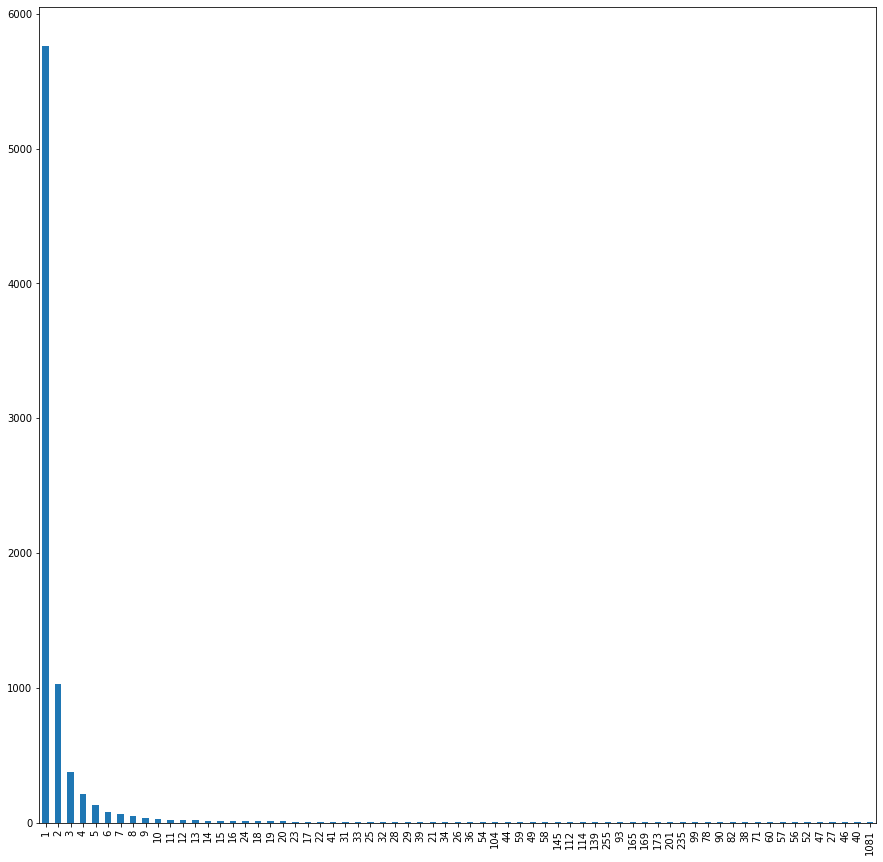

In [50]:
# take a look on bar chart of value counts
value_counts.plot.bar(figsize=(15,15))

In [51]:
# try to filter tags which count less than 5
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1081
1,tag#machine-learning,255
2,tag#django,235
3,tag#deep-learning,201
4,tag#tensorflow,173


In [52]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] >= 5]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#asynchronous,tag#tensorflow-tutorials,tag#embeddings,tag#e-commerce,tag#plotly-dash,tag#icon-font,tag#editor,tag#decentralized,tag#pycharm,tag#wrapper
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1081
1,tag#machine-learning,255
2,tag#django,235
3,tag#deep-learning,201
4,tag#tensorflow,173


<AxesSubplot:>

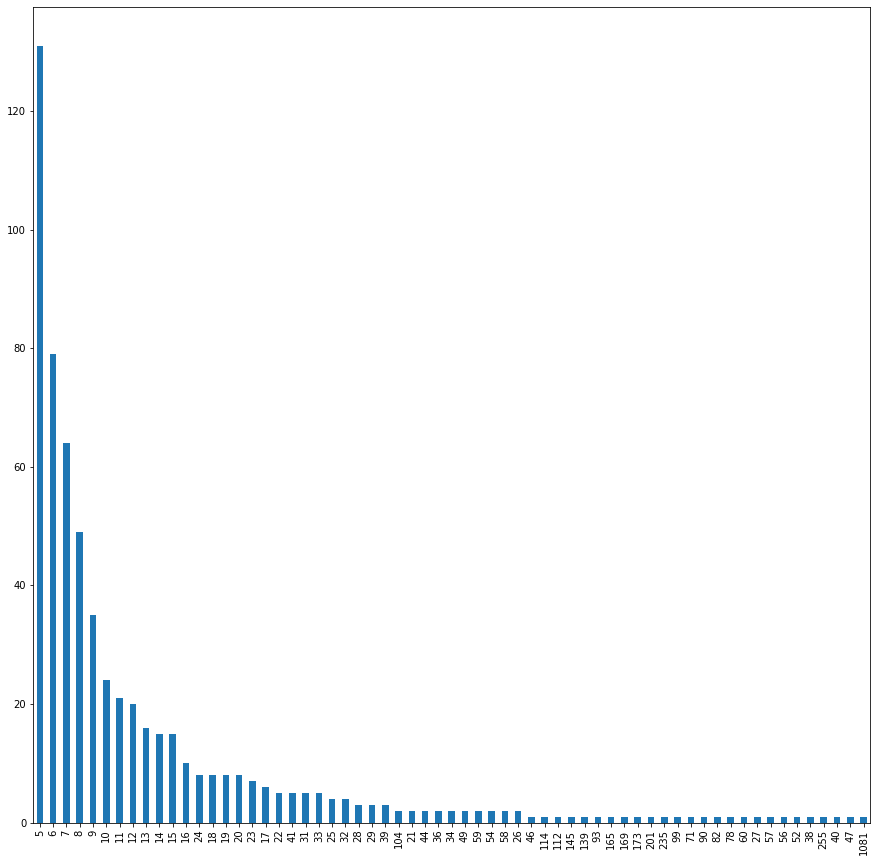

In [54]:
# check bar chart of value counts again
count_tags_usage_dataset["count"].value_counts().plot.bar(figsize=(15,15))

In [55]:
# I like count 10, lets filter tags with count less than 10
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] >= 10]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#cryptocurrencies,tag#cross-platform,tag#code-review,tag#transformers,tag#translation,tag#c,tag#tools,tag#scala,tag#matplotlib,tag#scrapy
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Lets check the rest of tags - looks good to me
tags_dataset.columns.tolist()

['tag#python',
 'tag#machine-learning',
 'tag#django',
 'tag#deep-learning',
 'tag#tensorflow',
 'tag#python3',
 'tag#flask',
 'tag#kotlin',
 'tag#android',
 'tag#hacktoberfest',
 'tag#bot',
 'tag#scikit-learn',
 'tag#nlp',
 'tag#pytorch',
 'tag#docker',
 'tag#telegram',
 'tag#linux',
 'tag#data-science',
 'tag#security',
 'tag#cryptocurrency',
 'tag#gradle',
 'tag#cli',
 'tag#java',
 'tag#api',
 'tag#keras',
 'tag#natural-language-processing',
 'tag#google',
 'tag#computer-vision',
 'tag#jupyter-notebook',
 'tag#bitcoin',
 'tag#aws',
 'tag#library',
 'tag#javascript',
 'tag#testing',
 'tag#ansible',
 'tag#data-visualization',
 'tag#wagtail',
 'tag#covid-19',
 'tag#algorithm',
 'tag#github-api',
 'tag#windows',
 'tag#json',
 'tag#git',
 'tag#neural-network',
 'tag#telegram-bot',
 'tag#terminal',
 'tag#twitter',
 'tag#ubuntu',
 'tag#pandas',
 'tag#jupyter',
 'tag#web',
 'tag#rest-api',
 'tag#automation',
 'tag#framework',
 'tag#parsing',
 'tag#font',
 'tag#monitoring',
 'tag#ethereum',


In [57]:
new_tags = tags_dataset.columns

In [58]:
# generate new columns of final dataset
new_final_dataset_columns = [c for c in final_dataset.columns if not c.startswith('tag#') or c in new_tags]

In [59]:
final_dataset.shape

(2412, 17100)

In [60]:
final_dataset = final_dataset[new_final_dataset_columns]

In [61]:
# new shape
final_dataset.shape

(2412, 8247)

In [62]:
final_dataset.head()

,project_name,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Filter projects which hasn't any tag form our new tag set

In [63]:
# Count such unlucky projects
final_dataset[new_tags].sum(1).value_counts()

3     569
2     541
4     384
1     311
5     263
6     146
7      64
8      46
0      26
10     24
9      24
12      5
13      5
11      3
14      1
dtype: int64

In [64]:
# So we have 439 projects without any tag from our new tag set
# And we have two options:
# First - leave it untouched and fit classifier on full negative projects too
# Second - filter it
# So hard choice :)

In [65]:
# Lets leave it as it is for now

# Export final dataset

In [66]:
final_dataset.head()

,project_name,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
final_dataset.shape

(2412, 8247)

In [68]:
final_dataset.to_csv("../data/classification/count_dataset_for_multilabel.csv", index=False)

In [69]:
final_columns = final_dataset.columns.to_frame(index=False, name="column_name")

In [70]:
final_columns.head()

,column_name
0,project_name
1,package#kotlin#B
2,package#kotlin#C
3,package#kotlin#Class
4,package#kotlin#Host


In [71]:
final_columns.to_csv("../data/pipeline/final_columns.csv", index=False)